In [1]:
import symlib
import matplotlib.pyplot as plt
import numpy as np
import os
from helpers.SimulationAnalysis import SimulationAnalysis, readHlist, a2z
import pandas as pd
from matplotlib import colormaps
import matplotlib.colors as mcolors

Core Question: "How is the amount of substructure in a halo related to the mass growth?"

Presumably with mass growth the amount of substructures will also grow, but we don't really know how well those are correlated.

Maybe create some kind of model that relates mass growth history with amount of substructure.

Keep track of "weird things" and parameters that are important.

Could definitely compare against WDM and SIDM in the future.

As part of the work on the project, set aside some time to read the papers you're using and try to understand them as well as you can.

In [2]:
# sim_dir is the location of a single halo. We'll talk about
# auto-generating this later, but if you downloaded "Halo933"
# in the suite "SymphonyLMC" to the directory "data/", this
# would be "data/SymphonyLMC/Halo933"

sim_dir = "D:/MWest_data/SymphonyLMC/Halo933/"
params = symlib.simulation_parameters(sim_dir)
print(params)

{'flat': True, 'H0': 70.0, 'Om0': 0.286, 'Ob0': 0.049, 'sigma8': 0.82, 'ns': 0.95, 'eps': 0.08, 'mp': 35247.6, 'h100': 0.7}


In [3]:
sim_dir1 = "D:/MWest_data/SymphonyCluster"
sim_dir2 = "D:/MWest_data/SymphonyGroup"
sim_dir3 = "D:/MWest_data/SymphonyLCluster"
sim_dir4 = "D:/MWest_data/SymphonyLMC"
sim_dir5 = "D:/MWest_data/SymphonyMilkyWay"

In [4]:
sym_cluster_halos = os.listdir(sim_dir1)
sym_group_halos = os.listdir(sim_dir2)
sym_lcluster_halos = os.listdir(sim_dir3)
sym_lmc_halos = os.listdir(sim_dir4)
sym_mw_halos = os.listdir(sim_dir5)

for i in range(len(sym_group_halos)):
    var = sym_group_halos[i]
    path = os.path.join("D:/MWest_data/SymphonyGroup", var)
    test_dir = path.replace("\\", "/")
    params = symlib.simulation_parameters(test_dir)

Example Subhalo Analysis: Plotting Postions

Our first step with analyzing any simulation data will be to look at it qualitatively. We’ll start by looking at the positions of the major Rockstar subhalos around our central halo at the last snapshot of the simulation. We will plot the central halo in one color and the subhalos in another. We’ll also need to avoid plotting any of the subhalos that were destroyed before the end of the simulation.

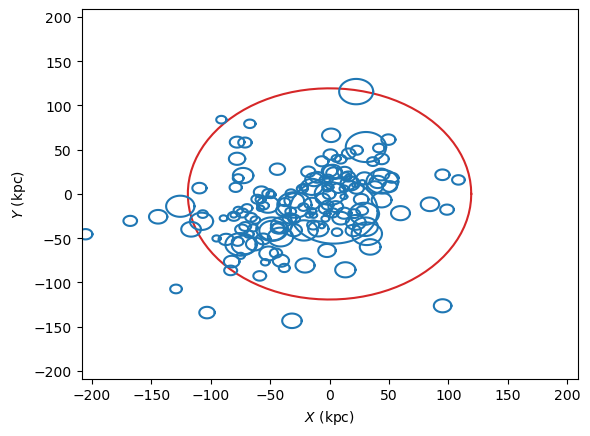

In [41]:
test_dir = "D:/MWest_data/SymphonyLMC/Halo032"

# read in sim data:
h, hist = symlib.read_subhalos(test_dir)

fig, ax = plt.subplots()

host = h[0, -1]  # first halo, last snapshot
symlib.plot_circle(ax, host["x"][0], host["x"][1], host["rvir"], c = "tab:red")

for i in range(1, len(h)):
    sub = h[i, -1]    # i-th subhalo, last snapshot
    if sub["ok"]:
        symlib.plot_circle(ax, sub['x'][0], sub['x'][1], sub['rvir'], c = "tab:blue", lw = 1.5)

# formatting code:

ax.set_xlim(-1.75*host["rvir"], 1.75*host["rvir"])
ax.set_ylim(-1.75*host["rvir"], 1.75*host["rvir"])
ax.set_xlabel(r"$X\ ({\rm kpc})$")
ax.set_ylabel(r"$Y\ ({\rm kpc})$")
plt.show()

**Example exercise**

In the histories array, there is a field called merger_snap that gives the snapshot when a subhalo first fell into the host. Try coloring subhalos that fell in from the left side of the halo (x_infall < 0) differently from ones that fell in from the right.

Example Analysis: Mass Growth

Now, we’ll try analysis that’s a bit more quantitative. We’ll look at the growth of subhalos over time: looking at the growth of the host halo and its five most massive subhalos over time. To do this, we’ll need to get the scale factors, for each snapshot with symlib.scale_factors(). We’ll also use one of the fields in histories, "merger_snap" which is the snapshot when the subhalo first fell into the host. We’ll use it to plot times before infall as dashed lines and times afterwards as solid lines.

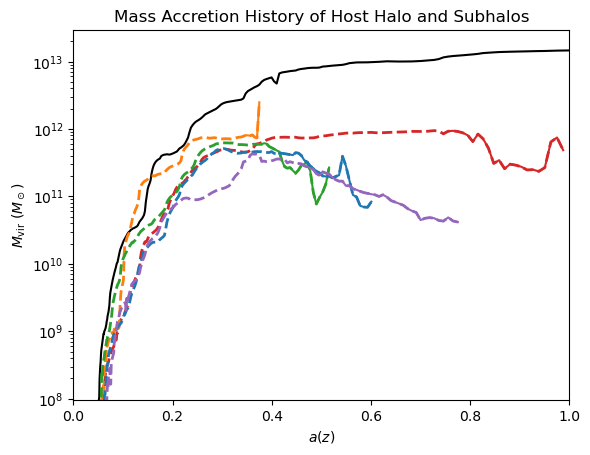

In [6]:
test_dir = "D:/MWest_data/SymphonyGroup/Halo015"

# read in sim data:
h, hist = symlib.read_subhalos(test_dir)
scale = symlib.scale_factors(test_dir)

# snapshots, for making cuts:
snaps = np.arange(len(h[0]))

fig, ax = plt.subplots()
colors = ['k', 'tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple']

for i in range(6):
    ok = h[i,:]['ok']  #snapshots where the halo exists
    if i == 0: # plot the host halo
        plt.plot(scale[ok], h[i,ok]["mvir"], c = colors[i])
    else:
        # plot the full history of the subhalo as a dashed line
        plt.plot(scale[ok], h[i,ok]['mvir'], "--", c = colors[i], lw = 2)
        # plot its history inside the host halo as a solid line
        is_sub = (snaps >= hist['merger_snap'][i]) & ok
        plt.plot(scale[is_sub], h[i, is_sub]['mvir'], c = colors[i])

# formatting code:

params = symlib.simulation_parameters("SymphonyGroup")
ax.set_xlim(0,1)
ax.set_ylim(30*params["mp"]/params["h100"], 2*h[0,-1]["mvir"])
ax.set_yscale("log")
ax.set_xlabel(r"$a(z)$")
ax.set_ylabel(r"$M_{\rm vir}\ (M_\odot)$")
ax.set_title("Mass Accretion History of Host Halo and Subhalos")
plt.show()

**Example exercise**

Try remaking this

You might have noticed that subhalos start losing mass before they actually start falling into the host (look at the transition from a dashed to solid line on the green curve in particular). Create a histogram showing r_peak/r_virial, where r_peak is the distance between the subhalo and the host halo and r_virial is the virial radius of the host halo, both calculated at the time the subhalo reaches its peak mass.

Example Analysis: The Subhalo Mass Functions

Lastly, let’s try some more rigorous statistical analysis. So far we’ve been looking at a population of subhalos surrounding one host halo. Now, we’re going to measure the subhalo mass function for all of the host halos in the Milky Way suite. The subhalo mass function is a statistic that counts the number of subhalos orbiting a host halo as a function of the subhalo’s mass. It is essentially a cumulative histogram of subhalo mass. We’ll need to look at , the average number of subhalos per host halo whose maximum mass was larger than.

In the previous exercise, we did analysis on the time when a subhalo reached its maximum mass, M_peak. We can calculate that value ourselves or use the "mpeak" field of the histories array.

More importantly, to get good statistics we’ll need to loop over all the host halos in the Milky Way suite, SymphonyMilkyWay. One way to do this would be to manually store the names of all the halo directories, but instead we’ll use library functions to do it. First, we’ll count the number of halos in the Milky Way-mass suite with symlib.n_hosts(). Then, we can get directory names symlib.get_host_directory(), which takes the base directory, suite name, and the index of the halo you want to read. Together this lets you loop over halo directories.

Constructing a mass function has a bit more code overhead than the earlier examples: the important part is how the loop over files works.

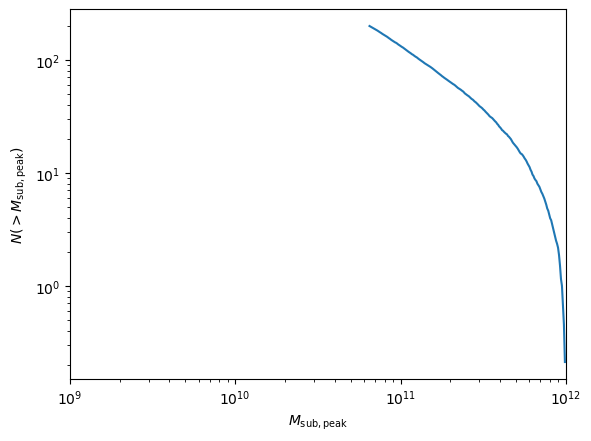

In [13]:
base_dir = "D:/MWest_data/"
suite = "SymphonyLCluster"

fig, ax = plt.subplots()

# setting up histogram bins:
params = symlib.simulation_parameters(suite)
m_min = params["mp"]/params["h100"]*300
m_max = 1e12
n_bins = 200
bins = 10**np.linspace(np.log10(m_min), np.log10(m_max), n_bins+1)

# set up cumulative histograms for mass functions:
N_infall = np.zeros(n_bins)
N_splashback = np.zeros(n_bins)
N_vir = np.zeros(n_bins)

n_hosts = symlib.n_hosts(suite)
for halo_num in range(n_hosts):
    sim_dir = symlib.get_host_directory(base_dir, suite, halo_num)

    # read in simulation data:
    h, hist = symlib.read_subhalos(sim_dir)

    # all surviving subhalos within R_vir:
    r = np.sqrt(np.sum(h['x'][:,-1]**2, axis = 1))
    host_rvir = h["rvir"][0,-1]
    ok = h['ok'][:,-1] & (r < host_rvir)
    n_vir, _ = np.histogram(hist["mpeak"][ok][1:], bins = bins)

    # add to the cumulative histograms:
    N_vir += np.cumsum(n_vir[::-1])[::-1]/n_hosts

# plot:
left_bins = bins[:-1]
plt.plot(left_bins, N_vir, c = "tab:blue")

# formatting plots:
ax.set_xlim(1e9, 1e12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$M_{\rm sub,peak}$")
ax.set_ylabel(r"$N(>M_{\rm sub,peak})$")
plt.show()

Example exercise

You might notice that the plot above only includes subhalos with positions within the virial radius of the host halo. Try adding a curve for the mass function of surviving “splashback” subhalos, subhalos which have temporarily orbited outside of the host halo’s virial radius, to this plot.

**Recreating Fig 7 from the Arxiv paper:**

"Left panel: subhalo mass functions evaluated using virial mass at z = 0 for our five zoom-in simulation suites. Solid lines show mean
SHMFs stacked over each suite, and shaded bands show the corresponding 16th–84th percentile of the host-to-host scatter. The dotted–dashed
Group result shows the SHMF at z = 0.5, when the corresponding host halos were mass-selected in their parent box. Vertical dotted lines show
the convergence limit for each simulation, calculated as 300 times the dark matter particle mass in the highest-resolution zoom-in region, and
lines transition from solid to dashed at the median Msub/Mhost threshold corresponding to the convergence limit for each suite."

In [3]:
base_dir = "D:/MWest_data/"
suite_list = ["SymphonyCluster", "SymphonyGroup", "SymphonyLCluster", "SymphonyLMC", "SymphonyMilkyWay"]

# ["SymphonyCluster", "SymphonyGroup", "SymphonyLCluster", "SymphonyLMC", "SymphonyMilkyWay"]

def fig_7_gen(base_dir, suite_list):

    fig, ax = plt.subplots()

    for suite in range(len(suite_list)):
        print(suite+1, suite_list[suite])
    
        # setting up histogram bins:
        params = symlib.simulation_parameters(suite_list[suite])
        m_min = params["mp"]/params["h100"]*300
        m_max = 1e14
        n_bins = 1000
        bins = 10**np.linspace(np.log10(m_min), np.log10(m_max), n_bins+1)

        # set up cumulative histograms for mass functions:
        N_infall = np.zeros(n_bins)
        N_splashback = np.zeros(n_bins)
        N_vir = np.zeros(n_bins)

        n_hosts = symlib.n_hosts(suite_list[suite])

        for i_halo in range(n_hosts):
            sim_dir = symlib.get_host_directory(base_dir, suite_list[suite], i_halo)

            # read in simulation data:
            h, hist = symlib.read_subhalos(sim_dir)

            # all surviving subhalos within R_vir:
            r = np.sqrt(np.sum(h['x'][:,-1]**2, axis = 1))
            host_rvir = h["rvir"][0,-1]
            ok = h['ok'][:,-1] & (r < host_rvir)
            n_vir, _ = np.histogram(hist["mpeak"][ok][1:], bins = bins)

            # add to the cumulative histograms:
            N_vir += np.cumsum(n_vir[::-1])[::-1]/n_hosts

            progress= round(i_halo/n_hosts, 2) * 100

            print(sim_dir, f"{progress:.2f} % \r", end="", flush=True)
            
        
        colors = ['tab:red', 'tab:green', 'tab:orange', 'tab:purple', 'tab:blue']
        left_bins = bins[:-1]
        ax.set_xlim(1e6, 1e15)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_title("Figure 7 In Symphony Paper")
        ax.set_xlabel("M_sub in Solar Masses")
        ax.set_ylabel("N_sub (>M_sub)")
        ax.plot(left_bins, N_vir, c = colors[suite % len(colors)], label = suite_list[suite])
        ax.legend(loc = "upper right", fontsize=8)

# possibly put a cut on the distance so that only objects inside the virial radius get counted
# redo with rockstar??

1 SymphonyCluster
2 SymphonyGroupymphonyCluster\Halo734 99.00 % 
3 SymphonyLClusterhonyGroup\Halo985 98.00 % 
4 SymphonyLMC/SymphonyLCluster\Halo_050 97.00 % 
5 SymphonyMilkyWayhonyLMC\Halo933 97.00 %  
D:/MWest_data/SymphonyMilkyWay\Halo990 98.00 %  

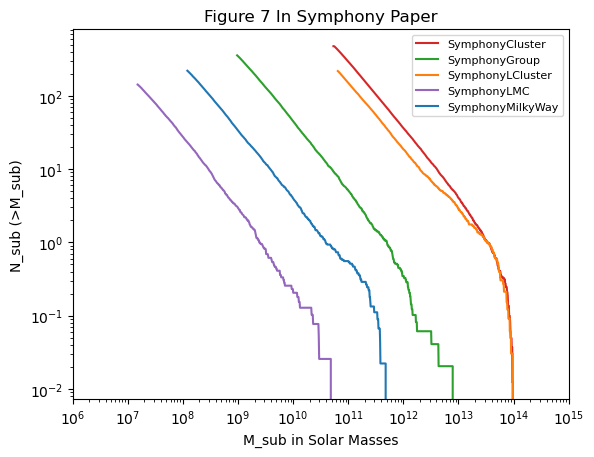

In [4]:
fig_7_gen(base_dir, suite_list)

**Recreating Fig 5:**

"Left panel: MAHs for the host halos in our five zoom-in simulation suites normalized to the z = 0 virial mass for each host. Solid
lines show mean MAHs for all hosts in each suite, and shaded bands show the corresponding 68% host-to-host scatter about the mean. Lines
transition to dashed at the redshift above which > 5% of the hosts in each suite are resolved with fewer than 300 particles. Jackknife resampling
of the LMC, Milky Way, and Group suites indicates that the difference between normalized MAHs is marginally significant at z & 2 and not
significant at later times; the difference between L-Cluster and Cluster MAHs is not statistically significant (see Section 3.4 for details). Dashed
(dotted–dashed) gray lines show best-fit MAHs using the Wechsler et al. (2002) exponential model and the Tasitsiomi et al. (2004) exponential
plus power-law model adopted by McBride et al. (2009b); best-fit parameters are provided in the text."

In [20]:
base_dir = "D:/MWest_data"
suite_list = ["SymphonyCluster", "SymphonyGroup", "SymphonyLCluster", "SymphonyLMC", "SymphonyMilkyWay"]


def fig_5_gen_all_lines(base_dir, suite_list):
    
    # create a figure to be modified later + colors
    fig, ax = plt.subplots()
    colors = ["tab:red", "tab:green", "tab:orange", "tab:purple", "tab:blue"]

    for suite in range(len(suite_list)):
        print(suite+1, suite_list[suite])

        n_hosts = symlib.n_hosts(suite_list[suite])
    
        for ith_host in range(n_hosts):
            sim_dir = symlib.get_host_directory(base_dir, suite_list[suite], ith_host)

            # Read in simulation data.
            h, hist = symlib.read_subhalos(sim_dir)
            scale = symlib.scale_factors(sim_dir)

            # Snapshots, for the purpose of making cuts
            snaps = np.arange(len(h[0]))

            for i in range(6):
                ok = h[i,:]["ok"] # Snapshots where the halo exists
                if i == 0:
                    # Plot the host halo
                    plt.plot(scale[ok], h[i,ok]["mvir"], c=colors[suite], lw = 1)
        
    # Some plotting code to make things look nice.
    param = symlib.simulation_parameters(suite_list[suite])
    ax.set_xlim(0, 1)
    ax.set_ylim(30*param["mp"]/param["h100"], 1000*h[0,-1]["mvir"])
    ax.set_yscale("log")
    ax.set_xlabel(r"$a(z)$")
    ax.set_ylabel(r"$M_{\rm vir}\ (M_\odot)$")
    plt.show()

1 SymphonyCluster
2 SymphonyGroup
3 SymphonyLCluster
4 SymphonyLMC
5 SymphonyMilkyWay


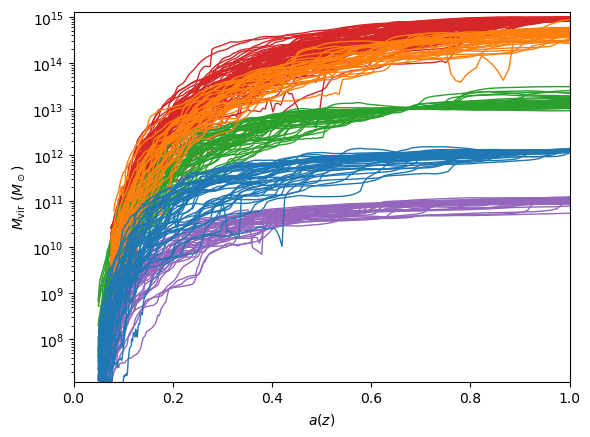

In [21]:
fig_5_gen_all_lines(base_dir, suite_list)

1 SymphonyLCluster
the suite has 33 halos in it
2 SymphonyCluster
the suite has 81 halos in it
3 SymphonyLMC
the suite has 39 halos in it
4 SymphonyGroup
the suite has 49 halos in it
5 SymphonyMilkyWay
the suite has 45 halos in it


C:\Users\steph\AppData\Local\Temp\ipykernel_13372\3876906282.py:66: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc = "upper left", fontsize = 6.5)


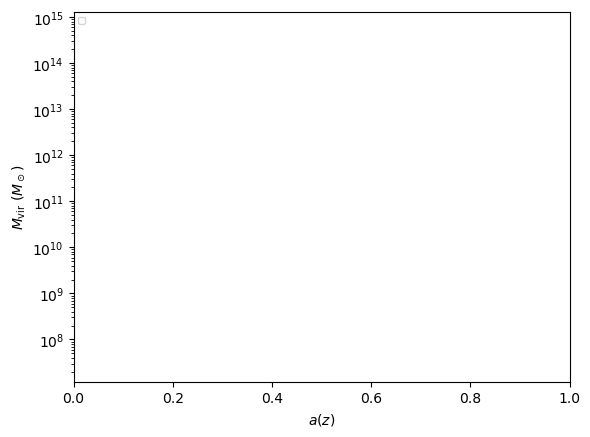

In [10]:
base_dir = "D:/MWest_data"
suite_list = ["SymphonyLCluster", "SymphonyCluster", "SymphonyLMC", "SymphonyGroup", "SymphonyMilkyWay"]


def fig_5_gen_avg_lines(base_dir, suite_list):
    
    # create a figure to be modified later + colors
    fig, ax = plt.subplots()
    colors = ["tab:orange", "tab:red", "tab:purple", "tab:green", "tab:blue"]


    # for each suite in the suite_list:
    for suite in range(len(suite_list)):
        print(suite+1, suite_list[suite])

    # assign n_hosts the value of the number of hosts in the suite
        n_hosts = symlib.n_hosts(suite_list[suite])
        print("the suite has", n_hosts, "halos in it")
        scale_factors = symlib.scale_factors(sim_dir)
        test_scale_factors = scale_factors[:4]

    # for each host in the suite, get the directory and read in the data

        tot_suite_mass_at_snap = 0
        tot_suite_mass = np.zeros(4)
        #tot_suite_mass = np.zeros(len(scale_factors))
        avg_suite_mass = np.zeros(4)
        #avg_suite_mass = np.zeros(len(scale_factors))

    # for each host in the suite:
        for ith_host in range(n_hosts):
            sim_dir = symlib.get_host_directory(base_dir, suite_list[suite], ith_host)
            s, hist = symlib.read_rockstar(sim_dir)          # read in simulation data

            n_snaps = len(scale_factors)                     # creates a variable of equal length to the number of entries in scale_factors
            test_snaps = len(test_scale_factors)

            tot_mass_at_snap = 0
            tot_halo_mass = np.zeros(4)
            #tot_halo_mass = np.zeros(len(scale_factors))
            avg_halo_mass = np.zeros(4)
            #avg_halo_mass = np.zeros(len(scale_factors))

    # for each snapshot corresponding to a value in scale_factors (time):
            for snap in range(test_snaps):
                total_mass = 0
                valid_count = 0
                mass = s[1, snap]["m"]                     # gives the virial mass of the 1st most massive halo (host halo) at that snapshot
                tot_halo_mass[snap] += mass                # add the mass at the current snapshot to the total mass







        
#ax.plot(scale_factors, avg_suite_mass, label = suite_list[suite], lw = 1.25, color = colors[suite])

            
        
# Some plotting code to make things look nice.
param = symlib.simulation_parameters(suite_list[suite])
ax.set_xlim(0, 1)


In [89]:
base_dir = "D:/MWest_data"
suite_list = ["SymphonyCluster", "SymphonyLCluster", "SymphonyGroup", "SymphonyMilkyWay", "SymphonyLMC"]

def fig_5_gen_avg_lines(base_dir, suite_list):

# create a figure to be modified later + colors
    fig, ax = plt.subplots(1, 2, figsize = (12,5))
    colors = ["tab:red", "tab:orange", "tab:green", "tab:blue", "tab:purple"]

# for each suite, get the number of hosts in the suite and prepare an empty list for the data
    for suite in range(len(suite_list)):
        total_hosts = symlib.n_hosts(suite_list[suite])
        host_data = []

        print(suite_list[suite], total_hosts)

# for each host in the suite, get the directory, read in the data and scale factors, calculate redshifts for later
        for j in range(total_hosts):
            sim_dir = symlib.get_host_directory(base_dir, suite_list[suite], j)
            r, _ = symlib.read_rockstar(sim_dir)
            scale_factors = symlib.scale_factors(sim_dir)
            redshifts = (1/scale_factors)-1
            n_snaps = len(scale_factors)
            host_data.append(r[0])  # host only

            average_masses = []
            normalized_average_masses = []

            progress = round(j/total_hosts, 2) * 100
            print(sim_dir, f"{progress:.2f} % \r", end="", flush=True)
        
            for snap in range(n_snaps):
                total_mass = 0
                valid_count = 0

                for r_host in host_data:
                    m = r_host[snap]['m']
                    ok = r_host[snap]["ok"]
                    if ok:
                        total_mass += m
                        valid_count += 1

                if valid_count > 0:
                    average_masses.append(total_mass / valid_count)
                    normalized_average_masses.append(total_mass / r_host[199]['m'])
                else:
                    average_masses.append(np.nan)
                    normalized_average_masses.append(np.nan)
                
        ax[1].plot(redshifts, average_masses, label = suite_list[suite], color = colors[suite])
        ax[0].plot(redshifts, normalized_average_masses, label = suite_list[suite], color = colors[suite])
    
    param = symlib.simulation_parameters(suite_list[suite])
    ax[0].invert_xaxis()
    ax[0].set_yscale("log")
    ax[0].set_xlabel(r"Redshift z")
    ax[0].set_ylabel(r"$M_{\rm vir}\ (M_\odot)$")
    ax[0].set_title(r"Normalized Average Masses vs Redshift For All Suites")
    ax[0].legend(loc = "upper left", fontsize = 6.5)

    ax[1].invert_xaxis()
    ax[1].set_yscale("log")
    ax[1].set_xlabel(r"Redshift z")
    ax[1].set_ylabel(r"$M_{\rm vir}\ (M_\odot)$")
    ax[1].set_title(r"Average Masses vs Redshift For All Suites")
    ax[1].legend(loc = "upper left", fontsize = 6.5)
    plt.show()

# could try taking log of scale factors and then do the transformation + x axis flip
# turn all the stuff we're doing into functions for later + making toggleable function values to allow us to not average every time
# turn off redshift, not plotting, etc.

SymphonyCluster 81
SymphonyLCluster 33onyCluster\Halo734 99.00 % 
SymphonyGroup 49mphonyLCluster\Halo_050 97.00 % 
SymphonyMilkyWay 45onyGroup\Halo985 98.00 % 
SymphonyLMC 39SymphonyMilkyWay\Halo990 98.00 %  
D:/MWest_data\SymphonyLMC\Halo933 97.00 %  

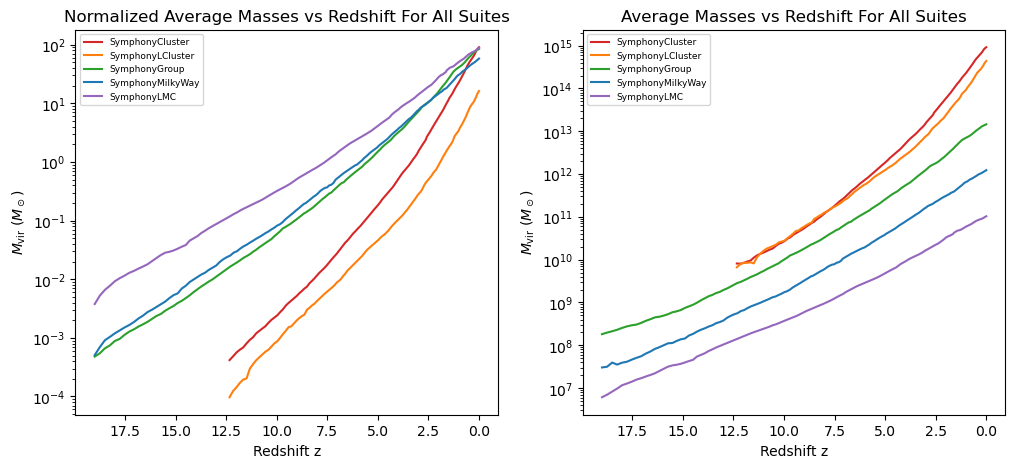

In [90]:
fig_5_gen_avg_lines(base_dir, suite_list)

**Week 3 (7/14):**

Repeat SHMF measurement at redshift 0.1, 0.2, 0.5, 1, 2. Plot each result separately in the style of Symphony Figure 6.

**Week 4 (7/21):**

Write script to automate SHMF measurement at any redshift. Test that it reproduces your Week 3 results.
Use script to measure total subhalo abundance, N_sub,tot, as a function of redshift. This can be for a single host.


In [20]:
import math
import matplotlib.cm as cm
import matplotlib.colors as mcolors

base_dir = "D:/MWest_data"
suite_list = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
redshifts = [0.1, 0.2, 0.5, 1.0, 2.0]

def shmf_any_redshifts(base_dir, suite_list, redshifts):

    og_colors = ["tab:purple", "tab:blue", "tab:green", "tab:orange", "tab:red"]

    # figure setup
    n_cols = 3
    n_rows = math.ceil(len(redshifts) / n_cols) 
    fig, axs = plt.subplots(n_rows, n_cols, figsize = (5 * n_cols, 4 * n_rows), sharex = True, sharey = True)
    axs = axs.flatten()


# for each redshift in the list of target redshifts
    for z_index, target_z in enumerate(redshifts):
        ax = axs[z_index]

        # for each suite in the list of suites
        for suite_index, suite_name in enumerate(suite_list):

            # create histogram bins
            params = symlib.simulation_parameters(suite_name)
            m_min = params["mp"]/params["h100"]*300
            m_max = 1e14
            n_bins = 300
            bins = 10**np.linspace(np.log10(m_min), np.log10(m_max), n_bins + 1)
            left_bins = bins[:-1]

            n_hosts = symlib.n_hosts(suite_name)        # get number of hosts
        
            test = np.zeros(n_bins)
    
            # get starting color for each suite:
            start_color = mcolors.to_rgb(og_colors[suite_index])
        
            red = start_color[0]
            green = start_color[1]
            blue = start_color[2]
            new_red = max(0, min(red + (z_index * 0.05), 1.0))        # Increase red channel
            new_green = max(0, min(green - (z_index * 0.01), 1.0))   # Decrease green channel
            new_blue = max(0, min(blue - (z_index * 0.01), 1.0))     #  Decrease blue channel
        
            color = (new_red, new_green, new_blue)

            # for each subhalo in the suite
            for i_host in range(n_hosts):
                sim_dir = symlib.get_host_directory(base_dir, suite_name, i_host)        # get directory to host

                #print(target_z, suite_name, sim_dir)

                scale_factors = symlib.scale_factors(sim_dir)      # read in scale factors list
                target_a = 1 / (1 + target_z)                    # convert from target redshift to corresponding scale factor or snapshot
                snap_index = np.argmin(np.abs(scale_factors - target_a))   # round to closest snapshot

                h, hist = symlib.read_subhalos(sim_dir)  # read in data

                # figure out which subhalos exist within the virial radius of the host halo at a given snapshot
                r = np.sqrt(np.sum(h["x"][:, snap_index]**2, axis = 1))   # calculate the subhalo's distance
                host_rvir = h["rvir"][0, snap_index]                      # get the virial radius of the host halo
                ok = h["ok"][:, snap_index] & (r < host_rvir)             # only keep the halo if it's been okayed and inside the virial radius
                n_vir, _ = np.histogram(hist["mpeak"][ok][1:], bins = bins)      # add to histogram
                N_vir = np.cumsum(n_vir[::-1])[::-1]

                test += N_vir

            #print(i_host, n_hosts)

                if i_host == n_hosts-1:

                    label = suite_name
            
                    axs[z_index].plot(left_bins, test / n_hosts, color = color, lw = 1.0, label = label)
            
                    axs[z_index].set_xlim(1e6, 1e15)
                    axs[z_index].set_ylim(1e0, 1e3)
                    axs[z_index].set_xscale("log")
                    axs[z_index].set_yscale("log")
                    axs[z_index].set_title(f"SHMF Of All Suites At z = {target_z}")
                    axs[z_index].set_xlabel("Msub [M☉])")
                    axs[z_index].set_ylabel("# of subhalos (>M)")

                    # global title
                    handles, labels = axs[0].get_legend_handles_labels()
                    fig.legend(handles, labels, loc = (0.15, 0.95), ncol = len(suite_list), fontsize = 10)

    # remove unused axes
    for i in range(len(redshifts), len(axs)):
        fig.delaxes(axs[i])

    plt.show()

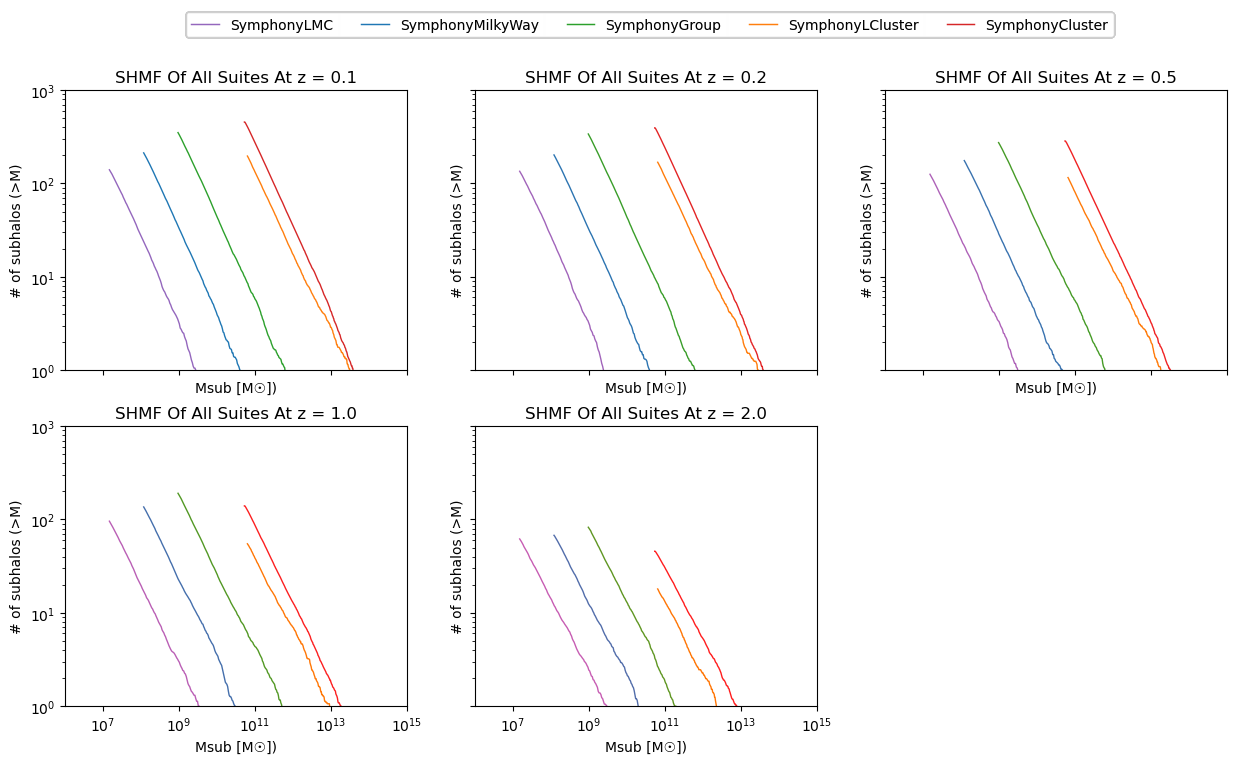

In [21]:
shmf_any_redshifts(base_dir, suite_list, redshifts)

**Week 4 (7/21):**

Write script to automate SHMF measurement at any redshift. Test that it reproduces your Week 3 results. Use script to measure total subhalo abundance, N_sub,tot, as a function of redshift. This can be for a single host.

In [2]:
base_dir = "D:/MWest_data"
suite_list = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
redshifts = [0.1, 0.2, 0.5, 1.0, 2.0]
og_colors = ["tab:purple", "tab:blue", "tab:green", "tab:orange", "tab:red"]

def nsub_vs_z(base_dir, suite_list, redshifts, og_colors):
    # figure setup
    fig, ax = plt.subplots(2, 3, figsize = (12, 10))
    ax = ax.flatten()

    # for each suite in the list of suites
    for suite_index, suite_name in enumerate(suite_list):
    
        params = symlib.simulation_parameters(suite_name)
        m_min = params["mp"]/params["h100"]*300
        m_max = 1e14
        n_bins = 1000
        bins = 10**np.linspace(np.log10(m_min), np.log10(m_max), n_bins + 1)
        h100 = params["h100"]
        n_hosts = symlib.n_hosts(suite_name)        # get number of hosts

        num_halos = np.zeros(len(redshifts))
        normalized_num_halos = np.zeros(len(num_halos))
        
        # for each subhalo in the suite
        for i_host in range(n_hosts):
            sim_dir = symlib.get_host_directory(base_dir, suite_name, i_host)        # get directory to host
            scale_factors = symlib.scale_factors(sim_dir)      # read in scale factors list
            h, hist = symlib.read_subhalos(sim_dir)  # read in data

            #print(sim_dir)

            for i_z, target_z in enumerate(redshifts):
                target_a = 1 / (1 + target_z)                    # convert from target redshift to corresponding scale factor or snapshot
                snap_index = np.argmin(np.abs(scale_factors - target_a))   # round to closest snapshot

                # filter out subhalos that aren't the host, are within the virial radius, and are still alive at the snapshot
                r = np.sqrt(np.sum(h["x"][:, snap_index]**2, axis = 1))   # calculate the subhalo's distance
                host_rvir = h["rvir"][0, snap_index]                      # get the virial radius of the host halo
                ok = h["ok"][:, snap_index] & (r < host_rvir) # only keep the halo if it's been okayed and a subhalo inside the virial radius

                # count # of subhalos inside host_rvir
                n_vir, _ = np.histogram(hist["mpeak"][ok][1:], bins = bins)
                
                num_halos[i_z] += np.sum(n_vir)

            normalized_num_halos = num_halos / num_halos[0]
                
            #num_halos /= n_hosts
            
            ax[suite_index].plot(redshifts, normalized_num_halos, color = og_colors[suite_index], lw = 1.0, label = suite_name)
        
        ax[suite_index].invert_xaxis()
        ax[suite_index].set_xlabel("Redshift (z)")
        ax[suite_index].set_ylabel("# of Subhalos")
        ax[suite_index].set_title(suite_name)

    # remove unused axes
    for i in range(len(redshifts), len(ax)):
        fig.delaxes(ax[i])

    fig.suptitle("Normalized # of Subhalos vs Redshift z For All Hosts In Each Suite", fontsize = 15)
    plt.tight_layout(rect = [0, 0.3, 1, 0.95])
    plt.show()

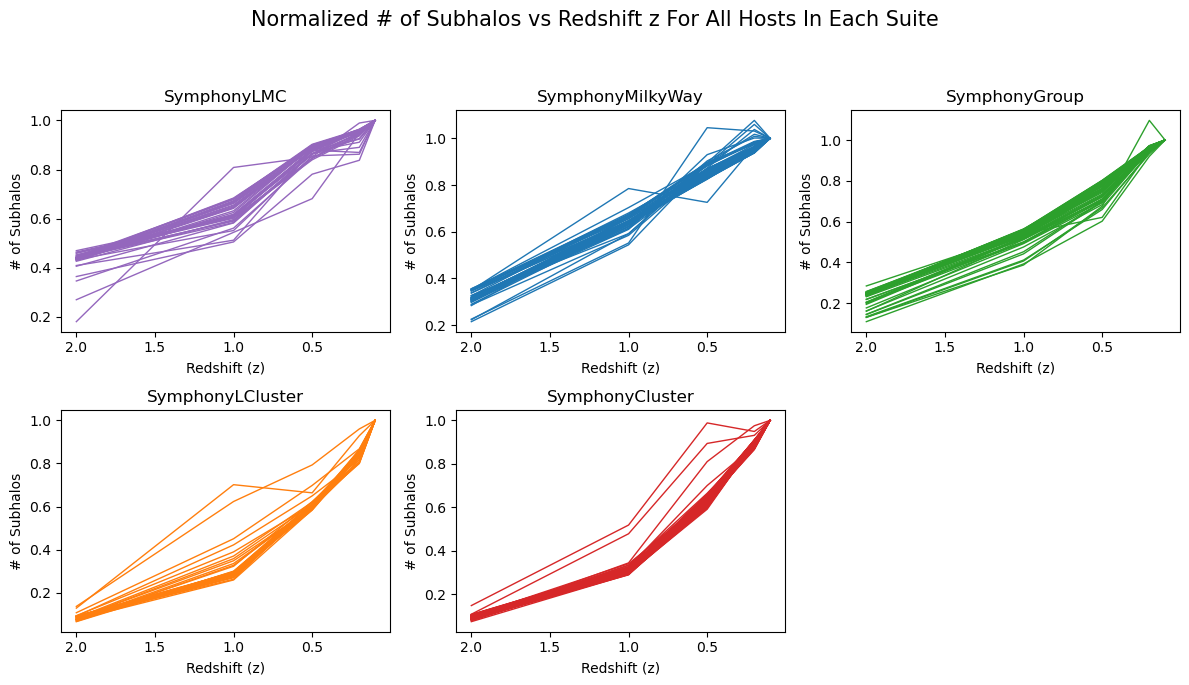

In [3]:
nsub_vs_z(base_dir, suite_list, redshifts, og_colors)

In [8]:
base_dir = "D:/MWest_data"
#suite_list = ["SymphonyLMC", "SymphonyLCluster"]
suite_list = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
redshifts = [0.1, 0.2, 0.5, 1.0, 2.0]
og_colors = ["tab:purple", "tab:blue", "tab:green", "tab:orange", "tab:red"]

def total_mass_vs_z(base_dir, suite_list, redshifts, og_colors):
    # figure setup
    fig, ax = plt.subplots(2, 3, figsize = (12, 10))
    ax = ax.flatten()

    # for each suite in the list of suites
    for suite_index, suite_name in enumerate(suite_list):
    
        params = symlib.simulation_parameters(suite_name)
        h100 = params["h100"]
    
        n_hosts = symlib.n_hosts(suite_name)        # get number of hosts

        total_mass = np.zeros(len(redshifts))
        normalized_total_mass = np.zeros(len(total_mass))
        
        # for each subhalo in the suite
        for i_host in range(n_hosts):
            sim_dir = symlib.get_host_directory(base_dir, suite_name, i_host)        # get directory to host
            scale_factors = symlib.scale_factors(sim_dir)      # read in scale factors list

            h, hist = symlib.read_subhalos(sim_dir)  # read in data

            #print(sim_dir)

            for i_z, target_z in enumerate(redshifts):
                target_a = 1 / (1 + target_z)                    # convert from target redshift to corresponding scale factor or snapshot
                snap_index = np.argmin(np.abs(scale_factors - target_a))   # round to closest snapshot
                
                host_mass = h["mvir"][0, snap_index]
                z0_mass = h["mvir"][0, -1]

                # filter out subhalos that aren't the host, are within the virial radius, and are still alive at the snapshot
                r = np.sqrt(np.sum(h["x"][:, snap_index]**2, axis = 1))   # calculate the subhalo's distance
                host_rvir = h["rvir"][0, snap_index]                      # get the virial radius of the host halo
                ok = h["ok"][:, snap_index] & (r < host_rvir)      # only keep the halo if it's been okayed at the current snapshot

                msun_mass = host_mass / h100    # host and subhalo mass, converted into solar masses

                total_mass[i_z] += msun_mass

                normalized_total_mass[i_z] = host_mass / z0_mass

            total_mass /= n_hosts
    
            ax[suite_index].plot(redshifts, normalized_total_mass, color = og_colors[suite_index], lw = 1.0, label = suite_name)
        
        
        ax[suite_index].invert_xaxis()
        ax[suite_index].set_xlabel("Redshift (z)")
        ax[suite_index].set_ylabel("Total Mass [M☉])")
        ax[suite_index].set_title(suite_name)

    # remove unused axes
    for i in range(len(redshifts), len(ax)):
        fig.delaxes(ax[i])

    fig.suptitle("Normalized Total Mass vs Redshift z For All Hosts In Each Suite", fontsize = 15)
    plt.tight_layout(rect = [0, 0.3, 1, 0.95])
    plt.show()

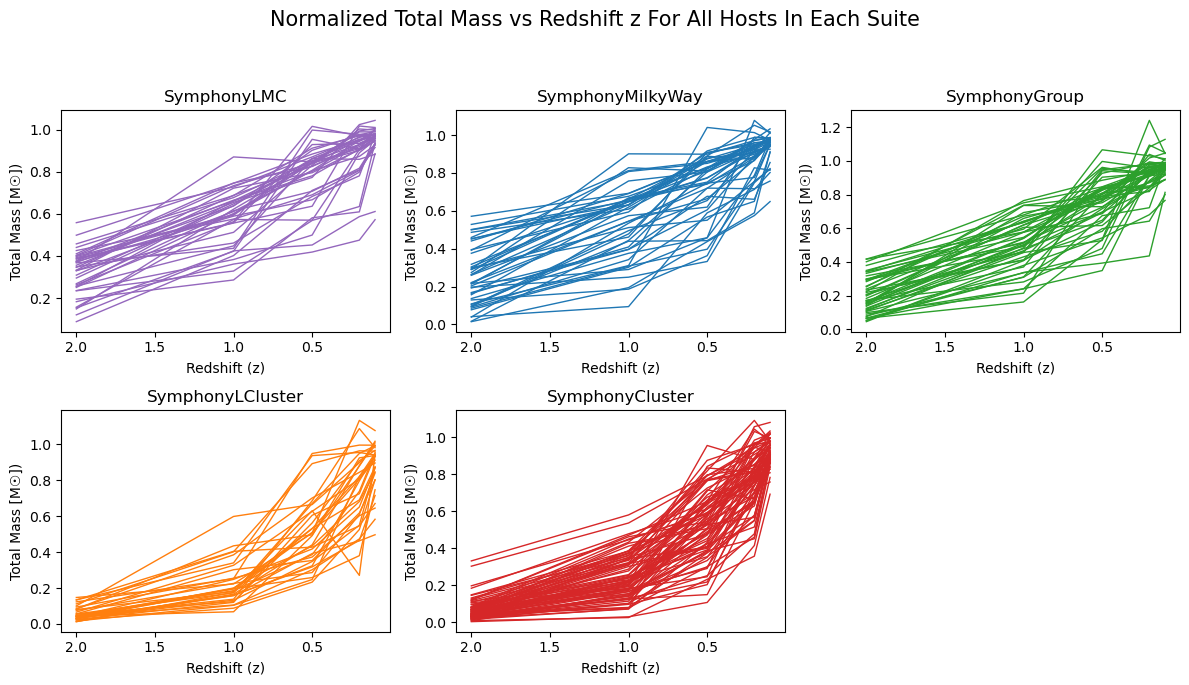

In [9]:
total_mass_vs_z(base_dir, suite_list, redshifts, og_colors)

Trying to combine the two plots:

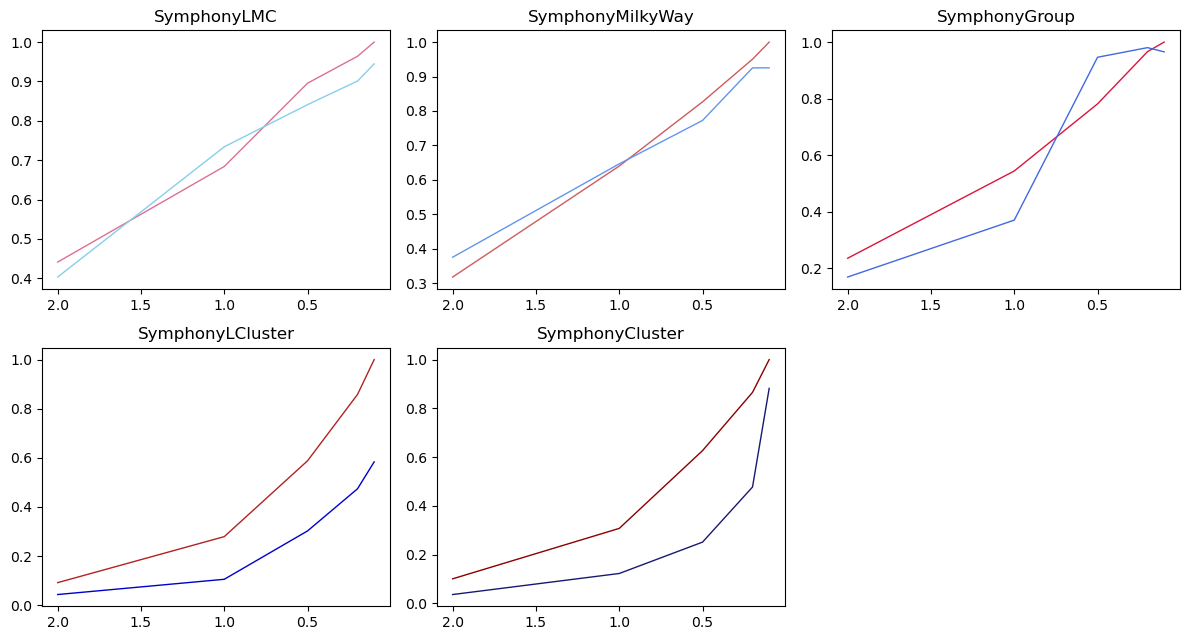

In [17]:
base_dir = "D:/MWest_data"
suite_list = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
redshifts = [0.1, 0.2, 0.5, 1.0, 2.0]
mass_colors = ["skyblue", "cornflowerblue", "royalblue", "mediumblue", "midnightblue"]
nsubs_colors = ["palevioletred", "indianred", "crimson", "firebrick", "darkred"]


# figure setup
fig, ax = plt.subplots(2, 3, figsize = (12, 10))
ax = ax.flatten()

# for each suite in the list of suites
for suite_index, suite_name in enumerate(suite_list):
    
    params = symlib.simulation_parameters(suite_name)
    m_min = params["mp"]/params["h100"]*300
    m_max = 1e14
    n_bins = 1000
    bins = 10**np.linspace(np.log10(m_min), np.log10(m_max), n_bins + 1)
    h100 = params["h100"]
    n_hosts = symlib.n_hosts(suite_name)        # get number of hosts

    num_halos = np.zeros(len(redshifts))
    normalized_num_halos = np.zeros(len(num_halos))
    total_mass = np.zeros(len(redshifts))
    normalized_total_mass = np.zeros(len(total_mass))
        
    # for each subhalo in the suite
    for i_host in range(n_hosts):
        sim_dir = symlib.get_host_directory(base_dir, suite_name, i_host)        # get directory to host
        scale_factors = symlib.scale_factors(sim_dir)      # read in scale factors list
        h, hist = symlib.read_subhalos(sim_dir)  # read in data

        #print(sim_dir)

        for i_z, target_z in enumerate(redshifts):
            target_a = 1 / (1 + target_z)                    # convert from target redshift to corresponding scale factor or snapshot
            snap_index = np.argmin(np.abs(scale_factors - target_a))   # round to closest snapshot

            host_mass = h["mvir"][0, snap_index]
            z0_mass = h["mvir"][0, -1]

            # filter out subhalos that aren't the host, are within the virial radius, and are still alive at the snapshot
            r = np.sqrt(np.sum(h["x"][:, snap_index]**2, axis = 1))   # calculate the subhalo's distance
            host_rvir = h["rvir"][0, snap_index]                      # get the virial radius of the host halo
            ok = h["ok"][:, snap_index] & (r < host_rvir) # only keep the halo if it's been okayed and a subhalo inside the virial radius

            # count # of subhalos inside host_rvir
            n_vir, _ = np.histogram(hist["mpeak"][ok][1:], bins = bins)

            num_halos[i_z] += np.sum(n_vir)

            msun_mass = host_mass / h100    # host and subhalo mass, converted into solar masses
            total_mass[i_z] += msun_mass
            normalized_total_mass[i_z] = host_mass / z0_mass

        total_mass /= n_hosts

        normalized_num_halos = num_halos / num_halos[0]
                
        #num_halos /= n_hosts
            
    ax[suite_index].plot(redshifts, normalized_num_halos, color = nsubs_colors[suite_index], lw = 1.0, label = suite_name)
    ax[suite_index].plot(redshifts, normalized_total_mass, color = mass_colors[suite_index], lw = 1.0, label = suite_name)
        
    ax[suite_index].invert_xaxis()
    #ax[suite_index].set_xlabel("Redshift (z)")
    #ax[suite_index].set_ylabel("# of Subhalos")
    ax[suite_index].set_title(suite_name)

# remove unused axes
for i in range(len(redshifts), len(ax)):
    fig.delaxes(ax[i])

#fig.suptitle("Normalized # of Subhalos vs Redshift z For All Hosts In Each Suite", fontsize = 15)
plt.tight_layout(rect = [0, 0.3, 1, 0.95])
plt.show()